In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [204]:
#Helper Functions , with the modified draw_lines() function
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines_original(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    ##LOGIC: Built on the original draw_lines_original function
    # Divide the lines into Left Lane & Right Lane lines based on their slope values
    # Fit a line equation to the left lane lines and another one to the right lane lines
    # Start the lines from the bottom of the image, or the maximum Y value of the image.
    # End the lines at the top where you find the mimimum Y value corresponding to the maximum X value for the left lane
    # Vice versa for the right lane
    # Draw these solid lines onto the blank canvas passed into the function
    
    image=img
    # Initialise arrays
    left_lane_points_x = []
    left_lane_points_y = []

    right_lane_points_x = []
    right_lane_points_y = []

    #plt.imshow(line_img, cmap="gray")
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            length = np.sqrt((y2-y1)*(y2-y1)+(x2-x1)*(x2-x1))
            if x1==x2 or y1==y2:
            
                continue #ignore vertical & horizontal lines

            if (not math.isnan(slope) and slope !=0):
                #print(slope)
                #Note: the Y axis is inverted, so +ve slope in image is actually -ve slope on normal axis
                if slope <0:

                    left_lane_points_x.append(x1)
                    left_lane_points_x.append(x2)

                    left_lane_points_y.append(y1)
                    left_lane_points_y.append(y2)

                    #print(">0",slope,left_lane_points)

                if slope >0:

                    right_lane_points_x.append(x1)
                    right_lane_points_x.append(x2)

                    right_lane_points_y.append(y1)
                    right_lane_points_y.append(y2)

    if len(left_lane_points_x) !=0 and len(right_lane_points_x) !=0:
        
        left_lane=np.polyfit(left_lane_points_x,left_lane_points_y,1)  
        right_lane=np.polyfit(right_lane_points_x,right_lane_points_y,1)  
        bottom_of_image_y=image.shape[0]
        
        left_lane_max_y=bottom_of_image_y
        left_lane_min_x=(left_lane_max_y-left_lane[1])/left_lane[0]
        

        left_lane_max_x=np.max(left_lane_points_x)
        left_lane_min_y=left_lane[0]*left_lane_max_x+left_lane[1]

        right_lane_min_x=np.min(right_lane_points_x)
        right_lane_min_y=right_lane[0]*right_lane_min_x+right_lane[1]

        #right_lane_max_x=np.max(right_lane_points_x)
        right_lane_max_y=bottom_of_image_y
        right_lane_max_x= (right_lane_max_y-right_lane[1])/right_lane[0]
        
        #print("left lane bottom",left_lane_min_x,left_lane_max_y)
        #print("left lane top",left_lane_max_x,left_lane_min_y)

        #print("right lane bottom",right_lane_max_x,right_lane_max_y)
        #print("right lane top",right_lane_min_x,right_lane_min_y)

        #line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        color=[255,0,0]
        thickness=4

        cv2.line(img, (int(left_lane_min_x), int(left_lane_max_y)), (int(left_lane_max_x), int(left_lane_min_y)), color, thickness)
        cv2.line(img, (int(right_lane_max_x), int(right_lane_max_y)), (int(right_lane_min_x), int(right_lane_min_y)), color, thickness)
        #return img
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [131]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [210]:
#The pipeline, converted to a convenient function that can be passed for video processing
def detect_lane_lines(image):
    #This function implements the entire pipeline.
    #0. First, filter out and keep only yellow & white images.
    #1. Convert image to grayscale
    #2. Apply Canny edge detection to detect edge outlines
    #3. Select the region of interest to limit to roughly the extent of lane lines
    #4a. Extract the hough lines, process the lines so that the Left Lane Line pieces are combined as 1 single solid line
    #4b. Similarly process the Right Lane Lin pieces. This processing is done in the modified draw_lines function
    #5. Overlay the processed Hough Lines onto the origina image
    
    #First convert image to HLS space, extract yellow & white lines
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white  mask
    lower_range = np.uint8([  0, 200,   0])
    upper_range = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower_range, upper_range)
    # yellow  mask
    lower_range = np.uint8([ 0,   0, 100])
    upper_range = np.uint8([ 50, 255, 255])
    yellow_mask = cv2.inRange(img, lower_range, upper_range)
    # combine  masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    final_mask = cv2.bitwise_and(image, image, mask = mask)
    
    gray=grayscale(final_mask)
    low_threshold=50
    high_threshold=150

    #Gaussian blur
    kernel_size=13
    gauss_blur= gaussian_blur(gray, kernel_size)

    canny_img=canny(gray, low_threshold, high_threshold)
    
    #Triangle defines the location of the lane lines
    left_bottom = [0, 539]
    right_bottom = [900, 539]
    apex = [500, 300]

    roi=region_of_interest(img=canny_img,vertices=np.array([ [left_bottom,right_bottom,apex] ], np.int32))
    # Pipeline step #3: Find lines using Hough transform
    hough_img=hough_lines(img=roi,max_line_gap=100,min_line_len=40,rho=2,theta=np.pi/180,threshold=45)
    #line_img=draw_lines(hough_img, lines, color=[255, 0, 0], thickness=2)
    
    # Pipeline step #4: Overlay the detected hough lines with the original image
    final_image = weighted_img(hough_img, image)
    
    return final_image

In [98]:
def select_color(image,threshold):
    # Read in the image
    #image = mpimg.imread('./test_images/solidWhiteCurve.jpg')

    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)

    # Define color selection criteria
    ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    red_threshold = threshold
    green_threshold = threshold
    blue_threshold = threshold
    ######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]

    #plt.subplot(1,2,1)
    #plt.imshow(image)
    #plt.subplot(1,2,2)                
    #plt.imshow(color_select)
    return color_select

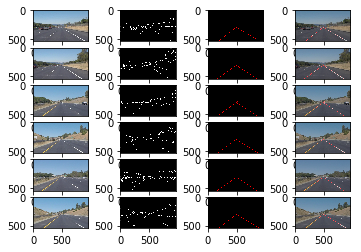

In [215]:
###THIS SNIPPET TESTS THE PIPELINE ON ALL THE TEST IMAGES, PLOTS THEM IN AN ARRAY
# Each row represents the process pipelines steps for each image and the final outut in the last column
# Note: the parameters for the Hough Transform, etc were heuristically chosen by trail and error

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

    
# Pipeline step 1: Take an image, convert to grayscale
test_images = [mpimg.imread('test_images/' + i) for i in os.listdir('test_images/')]
test_images_names=[i for i in os.listdir('test_images/')]
test_images_rows=len(test_images)
test_images_cols=4
image_no=0
plot_row=0
for test_image in test_images:
    image=test_image
    plt.subplot(test_images_rows,test_images_cols,1+plot_row)
    plt.imshow(image, cmap='gray')
    
    # Read in the image
    #image = mpimg.imread('/Users/nileshshah/SelfDrivingCarEngineerUdacity/Term1_Assignments/CarND-LaneLines-P1/test_images/whiteCarLaneSwitch.jpg')

    #Convert to grayscale
    gray=grayscale(image)

    # Display the image  
    #plt.imshow(gray, cmap='gray')

    # Pipeline step #3: Detect edges using Canny edge detector, but first apply gaussian blur so the not-so-strong edges are suppressed
    low_threshold=50
    high_threshold=150

    #Gaussian blur
    kernel_size=5
    gauss_blur= gaussian_blur(gray, kernel_size)

    canny_img=canny(gray, low_threshold, high_threshold)
    
    plt.subplot(test_images_rows,test_images_cols,2+plot_row)
    plt.imshow(canny_img, cmap='gray')
    # Pipeline step #2: Identify  regions that are not of interest
    # Define the vertices of a triangular mask.
    #  origin (x=0, y=0) is in the upper left
    #Triangle defines the location of the lane lines
    left_bottom = [130, 539]
    right_bottom = [900, 539]
    apex = [500, 300]

    roi=region_of_interest(img=canny_img,vertices=np.array([ [left_bottom,right_bottom,apex] ], np.int32))
    #plt.subplot(test_images_rows,test_images_cols,2+plot_row)
    #plt.imshow(roi, cmap='gray')

    # Pipeline step #3: Find lines using Hough transform
    hough_img=hough_lines(img=roi,max_line_gap=100,min_line_len=40,rho=2,theta=np.pi/180,threshold=45)
    plt.subplot(test_images_rows,test_images_cols,3+plot_row)
    plt.imshow(hough_img, cmap='gray')
    # Pipeline step #4: Overlay the detected hough lines with the original image
    final_image = weighted_img(hough_img, image)
    ## Plot final image
    plt.subplot(test_images_rows,test_images_cols,4+plot_row)
    plt.imshow(final_image)
    plot_row=plot_row+4
    output_image='./Solutions/' + test_images_names[image_no]
    image_no=image_no+1
    plt.imsave(output_image,final_image)

In [211]:
# This snippet tests the processing pipeline on videos

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = detect_lane_lines(image)
    #print(result.shape)
    return result

white_output = './solidWhiteRightOUTPUT.mp4'
clip1 = VideoFileClip("./test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

#yellow_output = './solidYellowLeftOUTPUT.mp4'
#clip2 = VideoFileClip("./test_videos/solidYellowLeft.mp4")
#yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
#%time yellow_clip.write_videofile(yellow_output, audio=False)

#challenge_output = './challengeOUTPUT.mp4'
#clip3 = VideoFileClip("./test_videos/challenge.mp4")
#challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
#%time challenge_clip.write_videofile(challenge_output, audio=False)



[MoviePy] >>>> Building video ./solidWhiteRightOUTPUT.mp4
[MoviePy] Writing video ./solidWhiteRightOUTPUT.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./solidWhiteRightOUTPUT.mp4 

CPU times: user 4.66 s, sys: 915 ms, total: 5.57 s
Wall time: 7.37 s


In [212]:
%matplotlib inline
HTML("""
<video width="960" height="540" controls>
  <source src="./solidWhiteRightOUTPUT.mp4">
</video>
""")


In [213]:
yellow_output = './solidYellowLeftOUTPUT.mp4'
clip2 = VideoFileClip("./test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video ./solidYellowLeftOUTPUT.mp4
[MoviePy] Writing video ./solidYellowLeftOUTPUT.mp4


100%|█████████▉| 681/682 [00:21<00:00, 32.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./solidYellowLeftOUTPUT.mp4 

CPU times: user 14.9 s, sys: 2.68 s, total: 17.5 s
Wall time: 21.7 s


In [214]:
%matplotlib inline
HTML("""
<video width="960" height="540" controls>
  <source src="./solidYellowLeftOUTPUT.mp4">
</video>
""")


In [190]:
challenge_output = './challengeOUTPUT.mp4'
clip3 = VideoFileClip("./test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./challengeOUTPUT.mp4
[MoviePy] Writing video ./challengeOUTPUT.mp4


100%|██████████| 251/251 [00:16<00:00, 15.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challengeOUTPUT.mp4 

CPU times: user 10.3 s, sys: 2.51 s, total: 12.8 s
Wall time: 18.5 s


In [191]:
%matplotlib inline

HTML("""
<video width="960" height="540" controls>
  <source src="./challengeOUTPUT.mp4">
</video>
""")


In [77]:
challenge_output = './challengeOUTPUT.mp4'
clip3 = VideoFileClip("./test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./challengeOUTPUT.mp4
[MoviePy] Writing video ./challengeOUTPUT.mp4


100%|██████████| 251/251 [00:16<00:00, 15.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challengeOUTPUT.mp4 

CPU times: user 8.01 s, sys: 1.73 s, total: 9.74 s
Wall time: 18.1 s


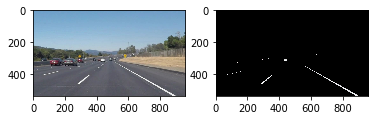

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('./test_images/solidWhiteCurve.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Define color selection criteria
###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200
######

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)                
plt.imshow(color_select)


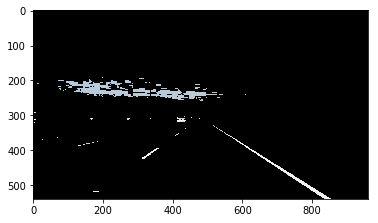

In [174]:
image = mpimg.imread('./test_images/solidWhiteRight.jpg')
# define color bundaries for white & yellow in HLS space
def select_white_yellow(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white  mask
    lower_range = np.uint8([  0, 200,   0])
    upper_range = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower_range, upper_range)
    # yellow  mask
    lower_range = np.uint8([ 0,   0, 200])
    upper_range = np.uint8([ 0, 255, 255])
    yellow_mask = cv2.inRange(img, lower_range, upper_range)
    # combine  masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    final_mask cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = select_white_yellow(image)
cmap=None
cmap = 'gray' if len(image.shape)==2 else cmap
plt.imshow(white_yellow_images,cmap)    

0.6*539

In [196]:
539*.6

323.4

In [198]:
x=4;t=6

In [199]:
t

6

In [200]:
if x>5 or t<10:
    print('ok')

ok


In [209]:
np.dot((3,2),5)

array([15, 10])